In [1]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

Using backend: pytorch


In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


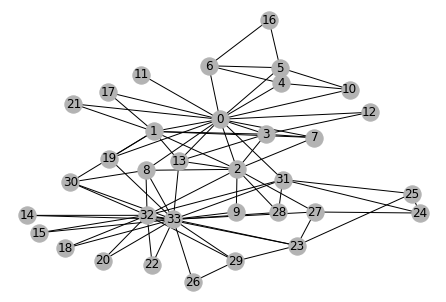

In [3]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [4]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [5]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 1.3774, -0.2169,  1.2166, -0.6590,  0.0663], grad_fn=<SelectBackward>)
tensor([[-0.1116,  2.0013,  0.2951,  0.2898, -1.5787],
        [ 0.1628, -0.4322,  0.1467, -0.5565,  0.0810]],
       grad_fn=<IndexBackward>)


In [6]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [7]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [8]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.9025
Epoch 1 | Loss: 0.8539
Epoch 2 | Loss: 0.8117
Epoch 3 | Loss: 0.7741
Epoch 4 | Loss: 0.7408
Epoch 5 | Loss: 0.7097
Epoch 6 | Loss: 0.6811
Epoch 7 | Loss: 0.6553
Epoch 8 | Loss: 0.6319
Epoch 9 | Loss: 0.6098
Epoch 10 | Loss: 0.5891
Epoch 11 | Loss: 0.5701
Epoch 12 | Loss: 0.5526
Epoch 13 | Loss: 0.5359
Epoch 14 | Loss: 0.5197
Epoch 15 | Loss: 0.5043
Epoch 16 | Loss: 0.4906
Epoch 17 | Loss: 0.4775
Epoch 18 | Loss: 0.4653
Epoch 19 | Loss: 0.4533
Epoch 20 | Loss: 0.4423
Epoch 21 | Loss: 0.4316
Epoch 22 | Loss: 0.4209
Epoch 23 | Loss: 0.4102
Epoch 24 | Loss: 0.3996
Epoch 25 | Loss: 0.3893
Epoch 26 | Loss: 0.3791
Epoch 27 | Loss: 0.3693
Epoch 28 | Loss: 0.3597
Epoch 29 | Loss: 0.3501
Epoch 30 | Loss: 0.3407
Epoch 31 | Loss: 0.3315
Epoch 32 | Loss: 0.3224
Epoch 33 | Loss: 0.3137
Epoch 34 | Loss: 0.3051
Epoch 35 | Loss: 0.2970
Epoch 36 | Loss: 0.2893
Epoch 37 | Loss: 0.2818
Epoch 38 | Loss: 0.2743
Epoch 39 | Loss: 0.2669
Epoch 40 | Loss: 0.2596
Epoch 41 | Loss: 0.2525
Ep

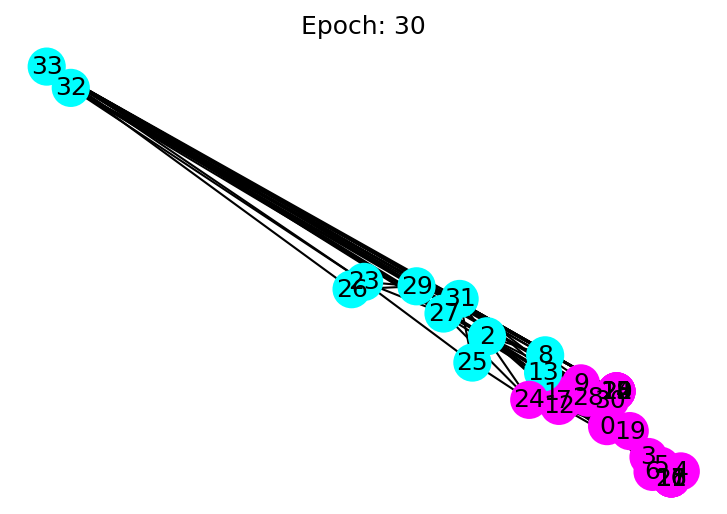

In [14]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(30)  # draw the prediction of the first epoch
#plt.close()

In [15]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)